<a href="https://colab.research.google.com/github/dados-cgimo-dtpar/X_FNTU_2025/blob/main/Evento_114/API_especiais_consumindo_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![x_fntpu_2025.png](https://raw.githubusercontent.com/halisson-gomides/bootcamps/refs/heads/main/X_FNTU_2025/x_fntpu_2025.png)

##  Aprenda a gerar um Painel das Transferências Especiais através da solução de Dados Abertos - API

 ### O que é uma API?



Imagine que você está em um restaurante. Você é o **cliente**, a cozinha é onde a comida é feita (um sistema complexo com chefs, ingredientes e utensílios), e o **garçom** é quem leva seu pedido (ex: "Eu quero um bife com batatas fritas") para a cozinha e traz a comida pronta de volta para você. Você não precisa saber como o chef prepara o bife, apenas que ele virá conforme o pedido.

Uma **API** (Application Programming Interface) é como esse **garçom, mas para programas de computador**.

É um conjunto de **regras e protocolos** que permite que diferentes aplicativos ou sistemas conversem entre si de forma organizada e segura. Pense nessas regras como um "contrato": ambos os lados (o programa que pede e o que responde) precisam seguir as regras para a comunicação funcionar. Um programa pode "pedir" informações (um request) ou "solicitar" uma tarefa a outro programa usando a API, sem precisar saber como o outro programa funciona por dentro, qual a linguagem de programação utilizada ou o sistema operacional.

### Para que serve?

1. **Conectar Programas**: Permite que um aplicativo use informações ou funções de
outro. Pense em um aplicativo de previsão do tempo no seu celular: ele usa uma API para buscar os dados mais recentes de um serviço central de meteorologia (como o INMET). O aplicativo faz uma requisição para a API do serviço de meteorologia, especificando a localização do usuário, e a API retorna os dados da previsão do tempo formatados para o aplicativo exibir. Isso evita que o desenvolvedor do app do tempo tenha que coletar e processar dados meteorológicos diretamente.

2. **Facilitar a Criação de Apps**: Desenvolvedores não precisam criar tudo do zero. Se precisam de um mapa em seu aplicativo, podem usar a API de um serviço de mapas já existente como o Google Maps API ou Mapbox API. Eles fornecem as ferramentas para exibir mapas, adicionar marcadores, calcular rotas, etc. Se precisam processar pagamentos online, usam a API de um sistema de pagamento como o Stripe API ou PayPal API, que cuidam da segurança e da complexidade das transações financeiras. Isso economiza tempo e recursos, permitindo que os desenvolvedores se concentrem na funcionalidade principal do aplicativo.

3. **Combinar Serviços**: Permite criar coisas novas juntando funcionalidades de diferentes fontes. Um site de viagens, por exemplo, pode usar APIs para buscar informações de voos (usando a API da Skyscanner ou Amadeus), hotéis (usando a API da Booking.com ou Expedia) e mapas (usando a API do Google Maps), tudo em um só lugar. O site faz requests para cada uma dessas APIs, combina os dados recebidos e apresenta ao usuário uma visão completa da viagem.

### Exemplos Práticos

* **Login com Redes Sociais**: Quando você clica em "Login com Google" ou "Login com Facebook" em um site, o site está usando a API do Google ou Facebook para autenticar sua identidade.
* **Integração com Calendários**: Um aplicativo de agendamento pode usar a API do Google Calendar ou Outlook Calendar para sincronizar seus compromissos.
* **Chatbots**: Chatbots usam APIs para entender a linguagem natural do usuário e fornecer respostas relevantes.

## Vamos praticar!

### Configuração do Ambiente

In [ ]:
! pip list | grep -E 'pandas|requests|urllib3|unidecode'

geopandas                             1.0.1
pandas                                2.2.2
pandas-datareader                     0.10.0
pandas-gbq                            0.29.0
pandas-stubs                          2.2.2.240909
requests                              2.32.3
requests-oauthlib                     2.0.0
requests-toolbelt                     1.0.0
sklearn-pandas                        2.2.0
text-unidecode                        1.3
urllib3                               2.4.0


In [ ]:
%%capture
# Caso a célula acima não gere nenhum retorno ou na lista retornada
# não conste uma ou mais das bilibotecas importadas na próxima célula,
# executar essa célula
!pip install pandas requests urllib3 unidecode

In [ ]:
import requests
import urllib3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from unidecode import unidecode
from io import StringIO

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 500)
pd.set_option('display.expand_frame_repr', True)

### Funções úteis

In [ ]:
def api_request(method, url, headers=None, params=None, data=None, json=None, resp_type='json', timeout=10):
    """
    Realiza uma requisição a uma API.

    Args:
        method: O método HTTP da requisição (GET, POST, PUT, DELETE, etc.).
        url: A URL da API.
        headers: Um dicionário com os headers da requisição.
        params: Um dicionário com os parâmetros da query string.
        data: Os dados da requisição (para métodos como POST e PUT).
        json: Os dados da requisição em formato JSON (para métodos como POST e PUT).
        timeout: O tempo limite da requisição em segundos.
        resp_type: O tipo de resposta desejado (json ou text).

    Returns:
        Um objeto Response do requests ou None em caso de erro.
    """
    try:
        response = requests.request(method, url, headers=headers, params=params, data=data, json=json, timeout=timeout)
        response.raise_for_status()  # Levanta uma exceção para status codes de erro (4xx ou 5xx)
        if resp_type == 'json':
            return response.json()
        elif resp_type == 'text':
            return response.text
        elif resp_type == 'headers':
            return response.headers
        return response
    except requests.exceptions.RequestException as e:
        print(f"Erro na requisição: {e.__repr__()}")
        return None


def millions_formatter(x, pos):
  return f'{x/1_000_000:.1f} Mi'

### Requisição a API - Transferências Especiais

In [ ]:
# Transferencias Especiais - Plano de ação Especiais
api_url = "https://api.transferegov.gestao.gov.br/transferenciasespeciais/plano_acao_especial"
ano_inicial = 2023
ano_final = 2024
qtd_pgs = 20
qtd_por_pag = 1000
lst_anos = [_i for _i in range(ano_inicial,ano_final + 1)]
lst_pgs = [_i for _i in range(qtd_pgs)]
df_paes_raw = pd.DataFrame()

for ano in lst_anos:
  for page in lst_pgs:
    api_params = {
        'ano_plano_acao': f'eq.{ano}',
        'offset': (page * qtd_por_pag),
        'limit': qtd_por_pag
    }
    result = api_request("GET", api_url, params=api_params)
    df_result = pd.DataFrame.from_dict(result, orient='columns')
    if df_result.empty:
      print('*'*100)
      break
    df_paes_raw = pd.concat([df_paes_raw, df_result])
    print(f"Ano: {ano:<5} Pg. {page:<5}- Qtd. Registros: {len(df_paes_raw.loc[df_paes_raw['ano_plano_acao'] == ano])}")
  else:
    print('*'*100)


print(f"\nTotal de linhas: {len(df_paes_raw)}\n")
df_paes_raw.head()

Ano: 2023  Pg. 0    - Qtd. Registros: 1000
Ano: 2023  Pg. 1    - Qtd. Registros: 2000
Ano: 2023  Pg. 2    - Qtd. Registros: 3000
Ano: 2023  Pg. 3    - Qtd. Registros: 4000
Ano: 2023  Pg. 4    - Qtd. Registros: 5000
Ano: 2023  Pg. 5    - Qtd. Registros: 6000
Ano: 2023  Pg. 6    - Qtd. Registros: 7000
Ano: 2023  Pg. 7    - Qtd. Registros: 8000
Ano: 2023  Pg. 8    - Qtd. Registros: 9000
Ano: 2023  Pg. 9    - Qtd. Registros: 9273
****************************************************************************************************
Ano: 2024  Pg. 0    - Qtd. Registros: 1000
Ano: 2024  Pg. 1    - Qtd. Registros: 2000
Ano: 2024  Pg. 2    - Qtd. Registros: 3000
Ano: 2024  Pg. 3    - Qtd. Registros: 4000
Ano: 2024  Pg. 4    - Qtd. Registros: 5000
Ano: 2024  Pg. 5    - Qtd. Registros: 6000
Ano: 2024  Pg. 6    - Qtd. Registros: 7000
Ano: 2024  Pg. 7    - Qtd. Registros: 8000
Ano: 2024  Pg. 8    - Qtd. Registros: 9000
Ano: 2024  Pg. 9    - Qtd. Registros: 10000
Ano: 2024  Pg. 10   - Qtd. Registros: 

,id_plano_acao,codigo_plano_acao,ano_plano_acao,modalidade_plano_acao,situacao_plano_acao,cnpj_beneficiario_plano_acao,nome_beneficiario_plano_acao,uf_beneficiario_plano_acao,codigo_banco_plano_acao,codigo_situacao_dado_bancario_plano_acao,nome_banco_plano_acao,numero_agencia_plano_acao,dv_agencia_plano_acao,numero_conta_plano_acao,dv_conta_plano_acao,nome_parlamentar_emenda_plano_acao,ano_emenda_parlamentar_plano_acao,codigo_parlamentar_emenda_plano_acao,sequencial_emenda_parlamentar_plano_acao,numero_emenda_parlamentar_plano_acao,codigo_emenda_parlamentar_formatado_plano_acao,codigo_descricao_areas_politicas_publicas_plano_acao,descricao_programacao_orcamentaria_plano_acao,motivo_impedimento_plano_acao,valor_custeio_plano_acao,valor_investimento_plano_acao,id_programa
0,30803,09032023-030803,2023,Especial,CIENTE,05990437000133,MUNICIPIO DE CALCOENE,AP,001,4.0,Banco do Brasil,3985.0,3,20324.0,6,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"15-Urbanismo / 451-Infraestrutura Urbana , 15-...","1007 , 1011 , 1012 , 1013 , 1015 , 1016",None,0.0,2066010.0,12
1,30804,09032023-030804,2023,Especial,CIENTE,05989116000119,MUNICIPIO DE AMAPA,AP,001,4.0,Banco do Brasil,3985.0,3,20325.0,4,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,15-Urbanismo / 451-Infraestrutura Urbana,"1006 - CONSTRUÇAO, REFORMA E AMPLIAÇAO DE PONT...",None,0.0,2066010.0,12
2,30805,09032023-030805,2023,Especial,CIENTE,23066632000153,MUNICIPIO DE TARTARUGALZINHO,AP,104,4.0,Caixa Econômica Federal,4707.0,4,6672006.0,8,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"6-Segurança Pública / 181-Policiamento , 6-Seg...","1006 - CONSTRUÇAO, REFORMA E AMPLIAÇAO DE PONT...",None,0.0,2066010.0,12
3,30806,09032023-030806,2023,Especial,CIENTE,34925131000100,MUNICIPIO DE PEDRA BRANCA DO AMAPARI,AP,104,4.0,Caixa Econômica Federal,3101.0,1,6672009.0,5,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"6-Segurança Pública / 181-Policiamento , 6-Seg...","1035 0000 Construção de Praças no Munucipio , ...",None,0.0,2066020.0,12
4,30807,09032023-030807,2023,Especial,CIENTE,34925198000136,MUNICIPIO DE CUTIAS,AP,104,4.0,Caixa Econômica Federal,2807.0,0,6672011.0,2,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,15-Urbanismo / 451-Infraestrutura Urbana,"1006- CONSTRUÇÃO, REFORMA E AMPLIAÇÃO DE PONTE...",None,0.0,2066010.0,12


#### Adicionando informações dos planos de trabalho relativos a cada plano de ação

In [ ]:
%%time
# Obtendo detalhamento dos Planos de Trabalho - Fonte: API de dados abertos do módulo de Transferências Especiais do Transferegov

df_pt_raw = pd.DataFrame()
min_id_plano_acao = df_paes_raw['id_plano_acao'].min()
max_id_plano_acao = df_paes_raw['id_plano_acao'].max()
url = f"https://api.transferegov.gestao.gov.br/transferenciasespeciais/plano_trabalho_especial?and(id_plano_acao.gte.{min_id_plano_acao},id_plano_acao.lte.{max_id_plano_acao})"
qtd_pgs = api_request("GET", url, headers={'Prefer': 'count=exact'}, resp_type='headers')
qtd_pgs = int(int(qtd_pgs['Content-Range'].split('/')[-1])/1000) + 1
qtd_por_pag = 1000
lst_pgs = [_i for _i in range(qtd_pgs)]


for page in lst_pgs:
  api_params = {
      'offset': (page * qtd_por_pag),
      'limit': qtd_por_pag,
      'order': 'id_plano_acao'
  }
  result = api_request("GET", url, params=api_params)
  df_result = pd.DataFrame.from_dict(result, orient='columns')
  if df_result.empty:
      print('*'*100)
      break
  df_pt_raw = pd.concat([df_pt_raw, df_result])
  print(f"Pg. {page:<5}- Qtd. Registros: {len(df_pt_raw)}")

print(f"\nTotal de linhas: {len(df_pt_raw)}")
df_pt_raw.head()

Pg. 0    - Qtd. Registros: 1000
Pg. 1    - Qtd. Registros: 2000
Pg. 2    - Qtd. Registros: 3000
Pg. 3    - Qtd. Registros: 4000
Pg. 4    - Qtd. Registros: 5000
Pg. 5    - Qtd. Registros: 6000
Pg. 6    - Qtd. Registros: 7000
Pg. 7    - Qtd. Registros: 8000
Pg. 8    - Qtd. Registros: 9000
Pg. 9    - Qtd. Registros: 10000
Pg. 10   - Qtd. Registros: 11000
Pg. 11   - Qtd. Registros: 12000
Pg. 12   - Qtd. Registros: 13000
Pg. 13   - Qtd. Registros: 14000
Pg. 14   - Qtd. Registros: 15000
Pg. 15   - Qtd. Registros: 16000
Pg. 16   - Qtd. Registros: 17000
Pg. 17   - Qtd. Registros: 18000
Pg. 18   - Qtd. Registros: 19000
Pg. 19   - Qtd. Registros: 20000
Pg. 20   - Qtd. Registros: 21000
Pg. 21   - Qtd. Registros: 22000
Pg. 22   - Qtd. Registros: 23000
Pg. 23   - Qtd. Registros: 24000
Pg. 24   - Qtd. Registros: 25000
Pg. 25   - Qtd. Registros: 26000
Pg. 26   - Qtd. Registros: 27000
Pg. 27   - Qtd. Registros: 28000
Pg. 28   - Qtd. Registros: 29000
Pg. 29   - Qtd. Registros: 30000
Pg. 30   - Qtd. Reg

,id_plano_trabalho,situacao_plano_trabalho,ind_orcamento_proprio_plano_trabalho,data_inicio_execucao_plano_trabalho,data_fim_execucao_plano_trabalho,prazo_execucao_meses_plano_trabalho,id_plano_acao,classificacao_orcamentaria_pt,ind_justificativa_prorrogacao_atraso_pt,ind_justificativa_prorrogacao_paralizacao_pt,justificativa_prorrogacao_pt
0,2268,Em Complementação,Sim,2020-06-26T00:00:00,2020-08-26T00:00:00,2,3192,AQUISIÇÃO DE VEICULO DE PASSEIO 05 LUGARES,False,False,
1,28913,Enviado para Análise,Sim,2020-06-26T00:00:00,2023-06-26T00:00:00,36,3193,Órgão: Secretaria Municipal de Serviços e Obra...,False,False,
2,7368,Enviado para Análise,Não,2020-06-26T00:00:00,2021-02-26T00:00:00,8,3194,,False,False,
3,23860,Em Complementação,Sim,2020-06-26T00:00:00,2023-06-26T00:00:00,36,3195,706 Transferência Especial da União - Controle...,False,False,
4,24638,Enviado para Análise,Sim,2020-06-26T00:00:00,2023-06-26T00:00:00,36,3196,ÓRGÃO.....: PREFEITURA MUNICIPAL DE TRES RANCH...,False,False,


#### Realizando o cruzamento dos dados e plano de ação com plano de trabalho

In [ ]:
# Cruzamento com o df de plano de acoes

df_paes_full = pd.merge(df_paes_raw, df_pt_raw, on='id_plano_acao', how='left', suffixes=('', '_pt'))
print(f"\nTotal de linhas: {len(df_paes_full)}")
df_paes_full.head()


Total de linhas: 20207


,id_plano_acao,codigo_plano_acao,ano_plano_acao,modalidade_plano_acao,situacao_plano_acao,cnpj_beneficiario_plano_acao,nome_beneficiario_plano_acao,uf_beneficiario_plano_acao,codigo_banco_plano_acao,codigo_situacao_dado_bancario_plano_acao,nome_banco_plano_acao,numero_agencia_plano_acao,dv_agencia_plano_acao,numero_conta_plano_acao,dv_conta_plano_acao,nome_parlamentar_emenda_plano_acao,ano_emenda_parlamentar_plano_acao,codigo_parlamentar_emenda_plano_acao,sequencial_emenda_parlamentar_plano_acao,numero_emenda_parlamentar_plano_acao,codigo_emenda_parlamentar_formatado_plano_acao,codigo_descricao_areas_politicas_publicas_plano_acao,descricao_programacao_orcamentaria_plano_acao,motivo_impedimento_plano_acao,valor_custeio_plano_acao,valor_investimento_plano_acao,id_programa,id_plano_trabalho,situacao_plano_trabalho,ind_orcamento_proprio_plano_trabalho,data_inicio_execucao_plano_trabalho,data_fim_execucao_plano_trabalho,prazo_execucao_meses_plano_trabalho,classificacao_orcamentaria_pt,ind_justificativa_prorrogacao_atraso_pt,ind_justificativa_prorrogacao_paralizacao_pt,justificativa_prorrogacao_pt
0,30803,09032023-030803,2023,Especial,CIENTE,05990437000133,MUNICIPIO DE CALCOENE,AP,001,4.0,Banco do Brasil,3985.0,3,20324.0,6,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"15-Urbanismo / 451-Infraestrutura Urbana , 15-...","1007 , 1011 , 1012 , 1013 , 1015 , 1016",None,0.0,2066010.0,12,20301.0,Enviado para Análise,Sim,2023-08-30T00:00:00,2024-08-30T00:00:00,12.0,449051,False,False,
1,30804,09032023-030804,2023,Especial,CIENTE,05989116000119,MUNICIPIO DE AMAPA,AP,001,4.0,Banco do Brasil,3985.0,3,20325.0,4,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,15-Urbanismo / 451-Infraestrutura Urbana,"1006 - CONSTRUÇAO, REFORMA E AMPLIAÇAO DE PONT...",None,0.0,2066010.0,12,22453.0,Em Complementação,Sim,2023-08-30T00:00:00,2024-04-30T00:00:00,8.0,2018 - Gestão das atividades da Secretaria Mun...,False,False,
2,30805,09032023-030805,2023,Especial,CIENTE,23066632000153,MUNICIPIO DE TARTARUGALZINHO,AP,104,4.0,Caixa Econômica Federal,4707.0,4,6672006.0,8,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"6-Segurança Pública / 181-Policiamento , 6-Seg...","1006 - CONSTRUÇAO, REFORMA E AMPLIAÇAO DE PONT...",None,0.0,2066010.0,12,23200.0,Em Complementação,Sim,2023-12-11T00:00:00,2024-08-11T00:00:00,8.0,2018 - Gestão das atividades da Secretaria Mun...,False,False,
3,30806,09032023-030806,2023,Especial,CIENTE,34925131000100,MUNICIPIO DE PEDRA BRANCA DO AMAPARI,AP,104,4.0,Caixa Econômica Federal,3101.0,1,6672009.0,5,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"6-Segurança Pública / 181-Policiamento , 6-Seg...","1035 0000 Construção de Praças no Munucipio , ...",None,0.0,2066020.0,12,21344.0,Enviado para Análise,Sim,2023-10-02T00:00:00,2026-10-02T00:00:00,36.0,26 0001 GESTÃO DA ADMINISTRAÇÃO MUNICIPAL\n04 ...,False,False,
4,30807,09032023-030807,2023,Especial,CIENTE,34925198000136,MUNICIPIO DE CUTIAS,AP,104,4.0,Caixa Econômica Federal,2807.0,0,6672011.0,2,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,15-Urbanismo / 451-Infraestrutura Urbana,"1006- CONSTRUÇÃO, REFORMA E AMPLIAÇÃO DE PONTE...",None,0.0,2066010.0,12,23699.0,Enviado para Análise,Sim,2023-08-30T00:00:00,2026-08-30T00:00:00,36.0,INFRAESTRUTURA URBANA,False,False,


### Análises e Verificações

#### Verificação se existem registros DUPLICADOS

In [ ]:
# Verificação se existem registros DUPLICADOS

assert df_paes_full.duplicated(subset=['id_plano_acao', 'codigo_plano_acao']).sum() == 0, "Existem registros DUPLICADOS"

#### Exporta o dataframe para Excel

In [ ]:
# Exporta o dataframe para Excel

df_paes_full.to_excel('trans_especiais_2022_2024.xlsx', index=False)

In [ ]:
df_paes_full = pd.read_excel('trans_especiais_2022_2024.xlsx', dtype=str)
df_paes_full.head()

,id_plano_acao,codigo_plano_acao,ano_plano_acao,modalidade_plano_acao,situacao_plano_acao,cnpj_beneficiario_plano_acao,nome_beneficiario_plano_acao,uf_beneficiario_plano_acao,codigo_banco_plano_acao,codigo_situacao_dado_bancario_plano_acao,nome_banco_plano_acao,numero_agencia_plano_acao,dv_agencia_plano_acao,numero_conta_plano_acao,dv_conta_plano_acao,nome_parlamentar_emenda_plano_acao,ano_emenda_parlamentar_plano_acao,codigo_parlamentar_emenda_plano_acao,sequencial_emenda_parlamentar_plano_acao,numero_emenda_parlamentar_plano_acao,codigo_emenda_parlamentar_formatado_plano_acao,codigo_descricao_areas_politicas_publicas_plano_acao,descricao_programacao_orcamentaria_plano_acao,motivo_impedimento_plano_acao,valor_custeio_plano_acao,valor_investimento_plano_acao,id_programa,id_plano_trabalho,situacao_plano_trabalho,ind_orcamento_proprio_plano_trabalho,data_inicio_execucao_plano_trabalho,data_fim_execucao_plano_trabalho,prazo_execucao_meses_plano_trabalho,classificacao_orcamentaria_pt,ind_justificativa_prorrogacao_atraso_pt,ind_justificativa_prorrogacao_paralizacao_pt,justificativa_prorrogacao_pt
0,30803,09032023-030803,2023,Especial,CIENTE,05990437000133,MUNICIPIO DE CALCOENE,AP,001,4,Banco do Brasil,3985,3,20324,6,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"15-Urbanismo / 451-Infraestrutura Urbana , 15-...","1007 , 1011 , 1012 , 1013 , 1015 , 1016",NaN,0,2066010,12,20301,Enviado para Análise,Sim,2023-08-30T00:00:00,2024-08-30T00:00:00,12,449051,False,False,NaN
1,30804,09032023-030804,2023,Especial,CIENTE,05989116000119,MUNICIPIO DE AMAPA,AP,001,4,Banco do Brasil,3985,3,20325,4,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,15-Urbanismo / 451-Infraestrutura Urbana,"1006 - CONSTRUÇAO, REFORMA E AMPLIAÇAO DE PONT...",NaN,0,2066010,12,22453,Em Complementação,Sim,2023-08-30T00:00:00,2024-04-30T00:00:00,8,2018 - Gestão das atividades da Secretaria Mun...,False,False,NaN
2,30805,09032023-030805,2023,Especial,CIENTE,23066632000153,MUNICIPIO DE TARTARUGALZINHO,AP,104,4,Caixa Econômica Federal,4707,4,6672006,8,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"6-Segurança Pública / 181-Policiamento , 6-Seg...","1006 - CONSTRUÇAO, REFORMA E AMPLIAÇAO DE PONT...",NaN,0,2066010,12,23200,Em Complementação,Sim,2023-12-11T00:00:00,2024-08-11T00:00:00,8,2018 - Gestão das atividades da Secretaria Mun...,False,False,NaN
3,30806,09032023-030806,2023,Especial,CIENTE,34925131000100,MUNICIPIO DE PEDRA BRANCA DO AMAPARI,AP,104,4,Caixa Econômica Federal,3101,1,6672009,5,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,"6-Segurança Pública / 181-Policiamento , 6-Seg...","1035 0000 Construção de Praças no Munucipio , ...",NaN,0,2066020,12,21344,Enviado para Análise,Sim,2023-10-02T00:00:00,2026-10-02T00:00:00,36,26 0001 GESTÃO DA ADMINISTRAÇÃO MUNICIPAL\n04 ...,False,False,NaN
4,30807,09032023-030807,2023,Especial,CIENTE,34925198000136,MUNICIPIO DE CUTIAS,AP,104,4,Caixa Econômica Federal,2807,0,6672011,2,Davi Alcolumbre,2023,3787,2,202337870002,202337870002-Davi Alcolumbre,15-Urbanismo / 451-Infraestrutura Urbana,"1006- CONSTRUÇÃO, REFORMA E AMPLIAÇÃO DE PONTE...",NaN,0,2066010,12,23699,Enviado para Análise,Sim,2023-08-30T00:00:00,2026-08-30T00:00:00,36,INFRAESTRUTURA URBANA,False,False,NaN


#### a) Top 10 parlamentares por quantidade de emendas, para cada ano.

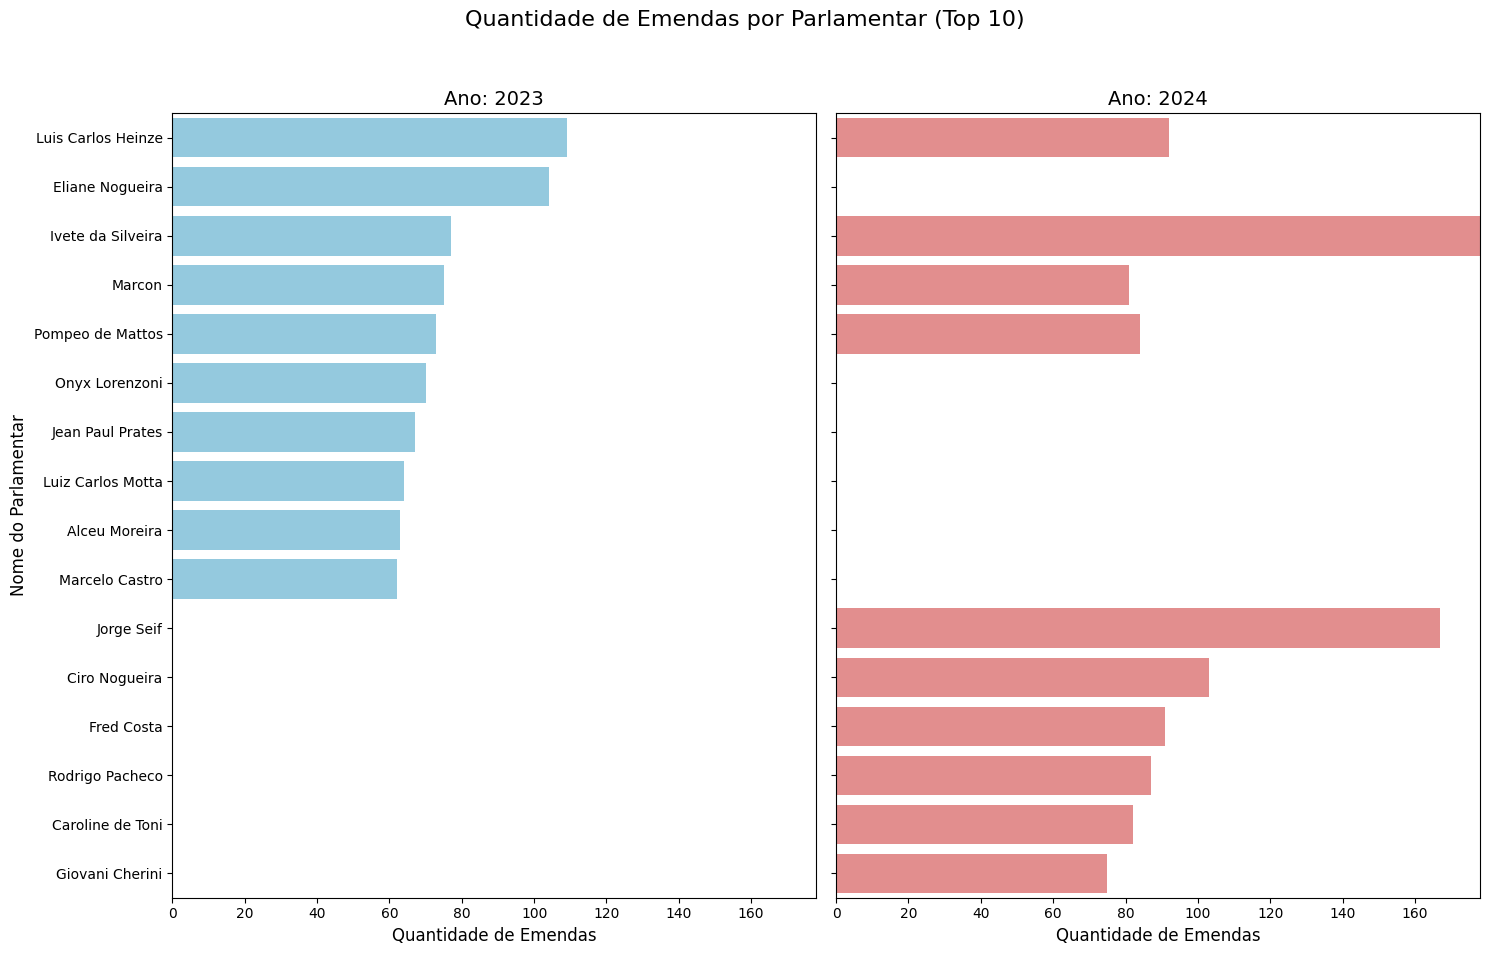

In [ ]:
# a) Top 10 parlamentares por quantidade de emendas, para cada ano.
# prompt: baseado no dataframe df_paes_full, gere 03 gráficos de qtd de emendas por nome_parlamentar_emenda_plano_acao, um para cada ano_emenda_parlamentar_plano_acao.
# O gráfico deve ser de barras horizontais, com o nome do parlamentar no eixo Y, com barras agrupadas representando as quantidades de cada ano.
# Ordene por qtd de emendas do maior para o menor, e exiba apenas os top 10. Exiba cada gráfico em um quadrante e varie as cores das barras para cada ano.


# Convertendo a coluna 'ano_emenda_parlamentar_plano_acao' para numérico
df_paes_full['ano_emenda_parlamentar_plano_acao'] = pd.to_numeric(df_paes_full['ano_emenda_parlamentar_plano_acao'], errors='coerce')

# Agrupando os dados e ordenando
emendas_por_parlamentar = df_paes_full.groupby(['nome_parlamentar_emenda_plano_acao', 'ano_emenda_parlamentar_plano_acao']).size().reset_index(name='quantidade')
emendas_por_parlamentar = emendas_por_parlamentar.sort_values(['ano_emenda_parlamentar_plano_acao', 'quantidade'], ascending=[True, False])

# Criando a figura e os eixos
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
fig.suptitle('Quantidade de Emendas por Parlamentar (Top 10)', fontsize=16)

max_value = emendas_por_parlamentar['quantidade'].max()
anos = emendas_por_parlamentar['ano_emenda_parlamentar_plano_acao'].unique()
cores = ['skyblue', 'lightcoral', 'lightgreen']

for i, ano in enumerate(anos):
  ax = axes[i]
  df_ano = emendas_por_parlamentar[emendas_por_parlamentar['ano_emenda_parlamentar_plano_acao'] == ano].head(10)

  sns.barplot(x='quantidade', y='nome_parlamentar_emenda_plano_acao', data=df_ano, ax=ax, color=cores[i], orient='h')

  ax.set_title(f'Ano: {int(ano)}', fontsize=14)
  ax.set_xlabel('Quantidade de Emendas', fontsize=12)
  ax.set_ylabel('Nome do Parlamentar', fontsize=12)
  ax.set_xlim(0, max_value) # mantém a mesma escala de valores entre os anos

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# Tirando a prova

df_paes_agrupado = (df_paes_full.groupby(['nome_parlamentar_emenda_plano_acao', 'ano_emenda_parlamentar_plano_acao'])
.agg({'numero_emenda_parlamentar_plano_acao': 'count', 'valor_custeio_plano_acao': 'sum', 'valor_investimento_plano_acao': 'sum'})
.reset_index())

df_paes_agrupado.loc[df_paes_agrupado['ano_emenda_parlamentar_plano_acao'] == 2023].sort_values('numero_emenda_parlamentar_plano_acao', ascending=False).head(10)

,nome_parlamentar_emenda_plano_acao,ano_emenda_parlamentar_plano_acao,numero_emenda_parlamentar_plano_acao,valor_custeio_plano_acao,valor_investimento_plano_acao
607,Luis Carlos Heinze,2023,109,5000020000500005000049128530000060000030000030...,0000000000000000000000000000290000025000050000...
319,Eliane Nogueira,2023,104,0000000000000000000000000000000000000000000000...,2824002824002824002824002824002824002824002824...
477,Ivete da Silveira,2023,77,0000000000000000000000000000000000000000000000...,1000001500000100000100000400000100000200000200...
661,Marcon,2023,75,0000000000000000000000000000000000000000000000...,1500002000001000002500002000002000002000001700...
829,Pompeo de Mattos,2023,73,0000000000000000000000000000000000000000000000...,2800001000002500001000001000002500001000001000...
756,Onyx Lorenzoni,2023,70,0000000000000000000000000000000000000000000000...,1000001000002000002000002000001500005000002000...
494,Jean Paul Prates,2023,67,0400000400000400000000400000004000000000000000...,4000000004000001500001476030150000400000040000...
618,Luiz Carlos Motta,2023,64,0000000000000000000000000000000000000000000000...,2000001000002000003000001000000100000200000400...
29,Alceu Moreira,2023,63,0000000000000000000000000000000000000000000000...,2500003000002174391000001000001800001200005000...
648,Marcelo Castro,2023,62,1000000001000001000001000000010000020000000020...,2000004000005000004000003000003000004000004000...


#### b) Top 10 parlamentares por valor de investimento, para cada ano

<ipython-input-14-1eb85171dd8c>:19: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_value) # mantém a mesma escala de valores entre os anos


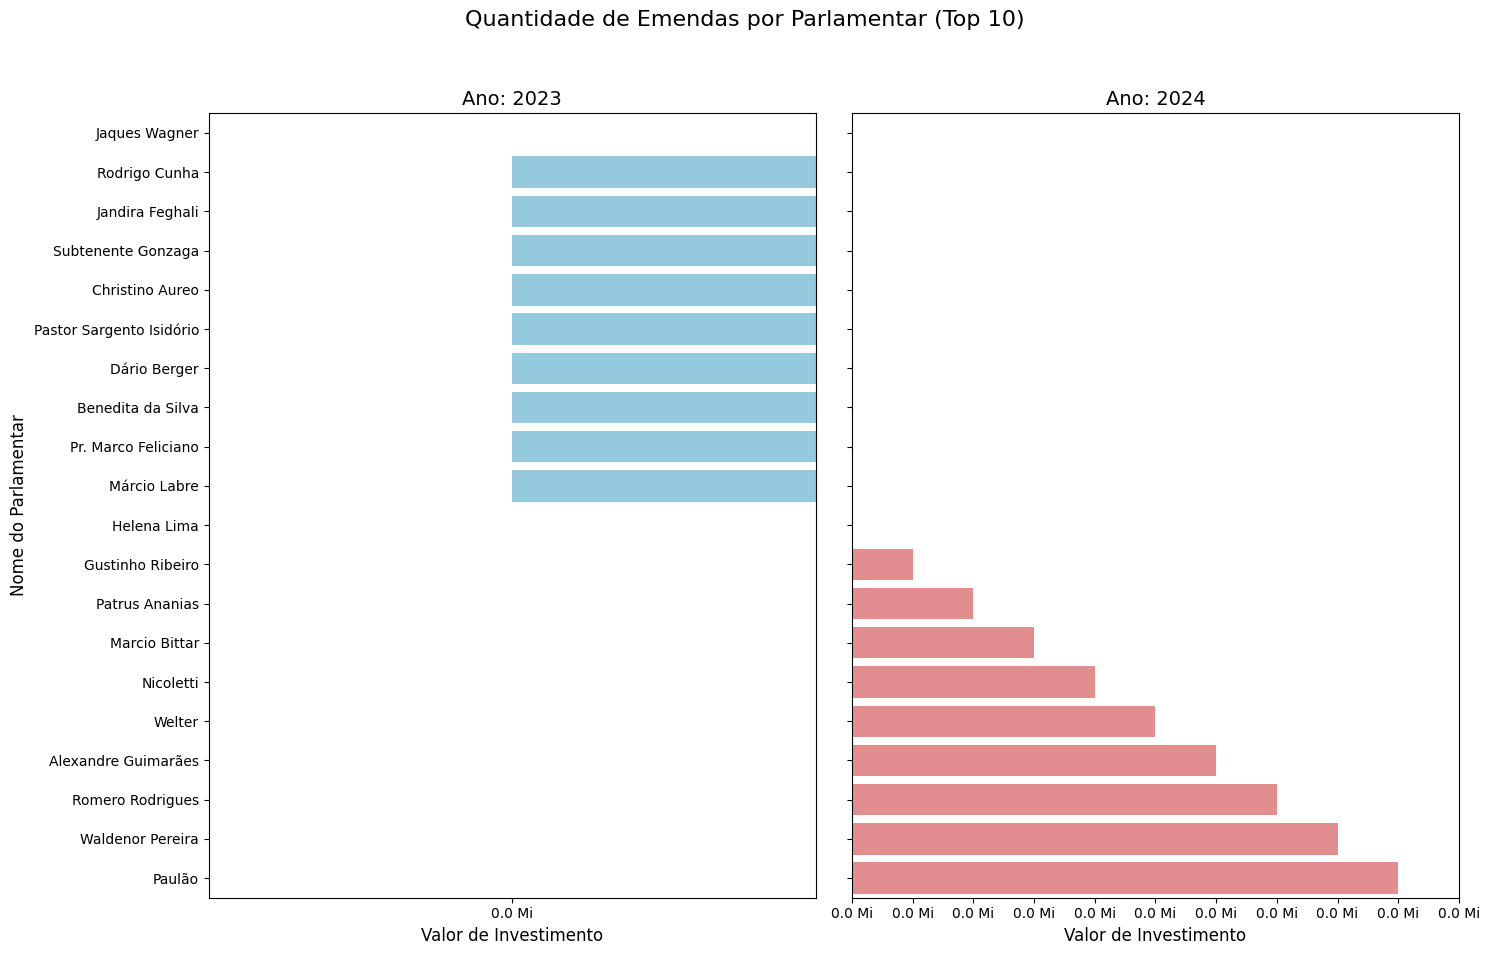

In [ ]:
# b) Top 10 parlamentares por valor de investimento, para cada ano

# Obtem o valor máximo de 'valor_investimento_plano_acao' independente do ano
max_value = df_paes_agrupado['valor_investimento_plano_acao'].max()

# Criando a figura e os eixos
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
fig.suptitle('Quantidade de Emendas por Parlamentar (Top 10)', fontsize=16)

for i, ano in enumerate(anos):
  ax = axes[i]
  df_ano = df_paes_agrupado.loc[df_paes_agrupado['ano_emenda_parlamentar_plano_acao'] == ano].sort_values('valor_investimento_plano_acao', ascending=False).head(10)

  sns.barplot(x='valor_investimento_plano_acao', y='nome_parlamentar_emenda_plano_acao', data=df_ano, ax=ax, color=cores[i], orient='h')

  ax.set_title(f'Ano: {int(ano)}', fontsize=14)
  ax.set_xlabel('Valor de Investimento', fontsize=12)
  ax.set_ylabel('Nome do Parlamentar', fontsize=12)
  ax.set_xlim(0, max_value) # mantém a mesma escala de valores entre os anos
  ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Requisição a API - Deputados Federais
- Fonte: Câmara dos Deputados

##### Obtendo os dados básicos de Deputados Federais

In [ ]:
# Dados sintéticos

api_url = "https://dadosabertos.camara.leg.br/api/v2/deputados"
qtd_pgs = 2
qtd_por_pag = 1000
df_dep_sint = pd.DataFrame()
for page in range(1, qtd_pgs+1):
  api_params = {
      'idLegislatura': '56,57',
      'itens': qtd_por_pag,
      'pagina': page,
  }
  result = api_request("GET", api_url, params=api_params)
  df_result = pd.DataFrame.from_dict(result['dados'], orient='columns')
  df_dep_sint = pd.concat([df_dep_sint, df_result])

print(f"Total de linhas: {len(df_dep_sint)}")
df_dep_sint.head()

Total de linhas: 1747


,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email
0,220593,https://dadosabertos.camara.leg.br/api/v2/depu...,Abilio Brunini,PL,https://dadosabertos.camara.leg.br/api/v2/part...,MT,57,https://www.camara.leg.br/internet/deputado/ba...,None
1,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PHS,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None
2,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PR,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None
3,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None
4,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PSC,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None


##### Aplicando a normalização do nome do deputado

In [ ]:
# Tratando o nome do Deputado

df_dep_sint['nome_tratado'] = df_dep_sint['nome'].apply(lambda x: unidecode(x.strip()).upper())
df_dep_sint.head()

,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email,nome_tratado
0,220593,https://dadosabertos.camara.leg.br/api/v2/depu...,Abilio Brunini,PL,https://dadosabertos.camara.leg.br/api/v2/part...,MT,57,https://www.camara.leg.br/internet/deputado/ba...,None,ABILIO BRUNINI
1,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PHS,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None,ABILIO SANTANA
2,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PR,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None,ABILIO SANTANA
3,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None,ABILIO SANTANA
4,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PSC,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None,ABILIO SANTANA


#### Obtendo detalhamento dos Deputados Federais - Fonte: Câmara dos Deputados

In [ ]:
%%time
# Obtendo detalhamento dos Deputados Federais - Fonte: Câmara dos Deputados

df_dep_raw = pd.DataFrame()
urls = df_dep_sint['uri'].unique()

for i, url in enumerate(urls):
  result = api_request("GET", url)
  df_result = pd.json_normalize(result['dados'])
  df_dep_raw = pd.concat([df_dep_raw, df_result])
  if i % 50 == 0:
    print(f"{i+1:>5} de {len(urls)}")

print(f"\nTotal de linhas: {len(df_dep_raw)}")
df_dep_raw.head()

    1 de 899
   51 de 899
  101 de 899
  151 de 899
  201 de 899
  251 de 899
  301 de 899
  351 de 899
  401 de 899
  451 de 899
  501 de 899
  551 de 899
  601 de 899
  651 de 899
  701 de 899
  751 de 899
  801 de 899
  851 de 899

Total de linhas: 899
CPU times: user 6.51 s, sys: 727 ms, total: 7.24 s
Wall time: 8min 42s


,id,uri,nomeCivil,cpf,sexo,urlWebsite,redeSocial,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,escolaridade,ultimoStatus.id,ultimoStatus.uri,ultimoStatus.nome,ultimoStatus.siglaPartido,ultimoStatus.uriPartido,ultimoStatus.siglaUf,ultimoStatus.idLegislatura,ultimoStatus.urlFoto,ultimoStatus.email,ultimoStatus.data,ultimoStatus.nomeEleitoral,ultimoStatus.gabinete.nome,ultimoStatus.gabinete.predio,ultimoStatus.gabinete.sala,ultimoStatus.gabinete.andar,ultimoStatus.gabinete.telefone,ultimoStatus.gabinete.email,ultimoStatus.situacao,ultimoStatus.condicaoEleitoral,ultimoStatus.descricaoStatus
0,220593,https://dadosabertos.camara.leg.br/api/v2/depu...,ABILIO JACQUES BRUNINI MOUMER,99770962104,M,None,[],1984-01-31,None,MT,Cuiabá,Superior,220593,https://dadosabertos.camara.leg.br/api/v2/depu...,Abilio Brunini,PL,None,MT,57,https://www.camara.leg.br/internet/deputado/ba...,None,2025-01-01,Abilio Brunini,None,None,None,None,None,None,Vacância,Titular,
0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,JOSE ABILIO SILVA DE SANTANA,36607606504,M,None,[],1965-02-13,None,BA,Salvador,Superior Incompleto,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PSC,None,BA,56,https://www.camara.leg.br/internet/deputado/ba...,None,2023-01-31,Abílio Santana,None,None,None,None,None,None,Fim de Mandato,Titular,None
0,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,PAULO SERGIO ABOU ANNI,08496582841,M,None,[https://www.facebook.com/DeputadoFederalAbouA...,1966-11-06,None,SP,São Paulo,Superior,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,Abou Anni,UNIÃO,None,SP,56,https://www.camara.leg.br/internet/deputado/ba...,None,2023-01-31,Abou Anni,None,None,None,None,None,None,Fim de Mandato,Titular,None
0,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,ACÁCIO DA SILVA FAVACHO NETO,74287028287,M,None,"[https://twitter.com/acaciofavacho, https://ww...",1983-09-28,None,AP,Macapá,Superior,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,None,AP,57,https://www.camara.leg.br/internet/deputado/ba...,None,2023-02-01,Acácio Favacho,414,4,414,4,3215-5414,dep.acaciofavacho@camara.leg.br,Exercício,Titular,None
0,220714,https://dadosabertos.camara.leg.br/api/v2/depu...,ADAIL JOSÉ FIGUEIREDO PINHEIRO,77267796249,M,None,[https://twitter.com/adailfilhoam?s=21&t=O_eoT...,1992-02-16,None,AM,Manaus,Superior Incompleto,220714,https://dadosabertos.camara.leg.br/api/v2/depu...,Adail Filho,REPUBLICANOS,None,AM,57,https://www.camara.leg.br/internet/deputado/ba...,None,2023-02-01,Adail Filho,531,4,531,5,3215-5531,dep.adailfilho@camara.leg.br,Exercício,Titular,None


In [ ]:
df_dep_raw.to_csv('deputados.csv', index=False)

In [ ]:
df_dep_raw = pd.read_csv('deputados.csv', dtype=str)
df_dep_raw.head()

,id,uri,nomeCivil,cpf,sexo,urlWebsite,redeSocial,dataNascimento,dataFalecimento,ufNascimento,municipioNascimento,escolaridade,ultimoStatus.id,ultimoStatus.uri,ultimoStatus.nome,ultimoStatus.siglaPartido,ultimoStatus.uriPartido,ultimoStatus.siglaUf,ultimoStatus.idLegislatura,ultimoStatus.urlFoto,ultimoStatus.email,ultimoStatus.data,ultimoStatus.nomeEleitoral,ultimoStatus.gabinete.nome,ultimoStatus.gabinete.predio,ultimoStatus.gabinete.sala,ultimoStatus.gabinete.andar,ultimoStatus.gabinete.telefone,ultimoStatus.gabinete.email,ultimoStatus.situacao,ultimoStatus.condicaoEleitoral,ultimoStatus.descricaoStatus
0,220593,https://dadosabertos.camara.leg.br/api/v2/depu...,ABILIO JACQUES BRUNINI MOUMER,99770962104,M,NaN,[],1984-01-31,NaN,MT,Cuiabá,Superior,220593,https://dadosabertos.camara.leg.br/api/v2/depu...,Abilio Brunini,PL,NaN,MT,57,https://www.camara.leg.br/internet/deputado/ba...,NaN,2025-01-01,Abilio Brunini,NaN,NaN,NaN,NaN,NaN,NaN,Vacância,Titular,NaN
1,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,JOSE ABILIO SILVA DE SANTANA,36607606504,M,NaN,[],1965-02-13,NaN,BA,Salvador,Superior Incompleto,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PSC,NaN,BA,56,https://www.camara.leg.br/internet/deputado/ba...,NaN,2023-01-31,Abílio Santana,NaN,NaN,NaN,NaN,NaN,NaN,Fim de Mandato,Titular,NaN
2,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,PAULO SERGIO ABOU ANNI,08496582841,M,NaN,['https://www.facebook.com/DeputadoFederalAbou...,1966-11-06,NaN,SP,São Paulo,Superior,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,Abou Anni,UNIÃO,NaN,SP,56,https://www.camara.leg.br/internet/deputado/ba...,NaN,2023-01-31,Abou Anni,NaN,NaN,NaN,NaN,NaN,NaN,Fim de Mandato,Titular,NaN
3,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,ACÁCIO DA SILVA FAVACHO NETO,74287028287,M,NaN,"['https://twitter.com/acaciofavacho', 'https:/...",1983-09-28,NaN,AP,Macapá,Superior,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,MDB,NaN,AP,57,https://www.camara.leg.br/internet/deputado/ba...,NaN,2023-02-01,Acácio Favacho,414,4,414,4,3215-5414,dep.acaciofavacho@camara.leg.br,Exercício,Titular,NaN
4,220714,https://dadosabertos.camara.leg.br/api/v2/depu...,ADAIL JOSÉ FIGUEIREDO PINHEIRO,77267796249,M,NaN,['https://twitter.com/adailfilhoam?s=21&t=O_eo...,1992-02-16,NaN,AM,Manaus,Superior Incompleto,220714,https://dadosabertos.camara.leg.br/api/v2/depu...,Adail Filho,REPUBLICANOS,NaN,AM,57,https://www.camara.leg.br/internet/deputado/ba...,NaN,2023-02-01,Adail Filho,531,4,531,5,3215-5531,dep.adailfilho@camara.leg.br,Exercício,Titular,NaN


#### Requisição a API - Senadores Federais
- Fonte: Senado Federal

##### Dados básicos dos senadores

In [ ]:
# URL: https://legis.senado.leg.br/dadosabertos/senador/lista/legislatura/56/57?v=4

lst_legislaturas = ['56', '57']
api_url = "https://legis.senado.leg.br/dadosabertos/senador/lista/legislatura/" + "/".join(lst_legislaturas)
api_params = {'v': 4}
api_header = {'Accept': 'application/json'}
result = api_request("GET", api_url, params=api_params, headers=api_header)

In [ ]:
result

In [ ]:
df_sen_parlamentares = pd.json_normalize(result,
                                 record_path=['ListaParlamentarLegislatura','Parlamentares','Parlamentar'])
print("Total de registros:", len(df_sen_parlamentares))
df_sen_parlamentares = df_sen_parlamentares.explode('Mandatos.Mandato')
print("Total de registros:", len(df_sen_parlamentares))
df_sen_parlamentares.columns = df_sen_parlamentares.columns.str.split('.').str[-1]
df_sen_parlamentares.rename(columns={'UfParlamentar': 'UfPessoal'}, inplace=True)
df_sen_parlamentares = df_sen_parlamentares.reset_index(drop=True)
df_sen_parlamentares.head()

Total de registros: 318
Total de registros: 327


,CodigoParlamentar,NomeParlamentar,NomeCompletoParlamentar,SexoParlamentar,FormaTratamento,SiglaPartidoParlamentar,Mandato,CodigoPublicoNaLegAtual,UrlFotoParlamentar,UrlPaginaParlamentar,UrlPaginaParticular,EmailParlamentar,UfPessoal
0,5573,Abel Rebouças,Abel Rebouças São José,Masculino,Senador,PDT,"{'CodigoMandato': '492', 'UfParlamentar': 'BA'...",NaN,NaN,NaN,NaN,NaN,NaN
1,4981,Acir Gurgacz,Acir Marcos Gurgacz,Masculino,Senador,PDT,"{'CodigoMandato': '515', 'UfParlamentar': 'RO'...",916,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,https://acirgurgacz.com.br/,sen.acirgurgacz@senado.leg.br,NaN
2,5918,Adilson Gomes,Adilson Gomes Silva,Masculino,Senador,NaN,"{'CodigoMandato': '526', 'UfParlamentar': 'PE'...",NaN,NaN,NaN,NaN,NaN,NaN
3,5625,Adilson Silva dos Santos,Adilson Silva dos Santos,Masculino,Senador,PEN,"{'CodigoMandato': '497', 'UfParlamentar': 'RS'...",NaN,NaN,NaN,NaN,NaN,NaN
4,6382,Adrian da Blukit,Adrian Rogers Censi,Masculino,Senador,NaN,"{'CodigoMandato': '613', 'UfParlamentar': 'SC'...",NaN,NaN,NaN,NaN,NaN,NaN


##### Dados de mandatos dos senadores

In [ ]:
df_sen_mandatos = pd.json_normalize(df_sen_parlamentares['Mandato'])
print(df_sen_mandatos.shape)
df_sen_mandatos = df_sen_mandatos.reset_index(drop=True)
df_sen_mandatos.head()

(327, 14)


,CodigoMandato,UfParlamentar,DescricaoParticipacao,PrimeiraLegislaturaDoMandato.NumeroLegislatura,PrimeiraLegislaturaDoMandato.DataInicio,PrimeiraLegislaturaDoMandato.DataFim,SegundaLegislaturaDoMandato.NumeroLegislatura,SegundaLegislaturaDoMandato.DataInicio,SegundaLegislaturaDoMandato.DataFim,Titular.DescricaoParticipacao,Titular.CodigoParlamentar,Titular.NomeParlamentar,Suplentes.Suplente,Exercicios.Exercicio
0,492,BA,1º Suplente,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,Titular,5523,Otto Alencar,"[{'DescricaoParticipacao': '2º Suplente', 'Cod...",NaN
1,515,RO,Titular,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,NaN,NaN,NaN,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...","[{'CodigoExercicio': '2810', 'DataInicio': '20..."
2,526,PE,2º Suplente,56,2019-02-01,2023-01-31,57,2023-02-01,2027-01-31,Titular,4545,Jarbas Vasconcelos,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...",NaN
3,497,RS,2º Suplente,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,Titular,5533,Lasier Martins,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...",NaN
4,613,SC,2º Suplente,57,2023-02-01,2027-01-31,58,2027-02-01,2031-01-31,Titular,6342,Jorge Seif,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...",NaN


##### Dados completos senadores

In [ ]:
df_senadores = pd.concat([df_sen_parlamentares, df_sen_mandatos], axis=1)
df_senadores.head()

,CodigoParlamentar,NomeParlamentar,NomeCompletoParlamentar,SexoParlamentar,FormaTratamento,SiglaPartidoParlamentar,Mandato,CodigoPublicoNaLegAtual,UrlFotoParlamentar,UrlPaginaParlamentar,UrlPaginaParticular,EmailParlamentar,UfPessoal,CodigoMandato,UfParlamentar,DescricaoParticipacao,PrimeiraLegislaturaDoMandato.NumeroLegislatura,PrimeiraLegislaturaDoMandato.DataInicio,PrimeiraLegislaturaDoMandato.DataFim,SegundaLegislaturaDoMandato.NumeroLegislatura,SegundaLegislaturaDoMandato.DataInicio,SegundaLegislaturaDoMandato.DataFim,Titular.DescricaoParticipacao,Titular.CodigoParlamentar,Titular.NomeParlamentar,Suplentes.Suplente,Exercicios.Exercicio
0,5573,Abel Rebouças,Abel Rebouças São José,Masculino,Senador,PDT,"{'CodigoMandato': '492', 'UfParlamentar': 'BA'...",NaN,NaN,NaN,NaN,NaN,NaN,492,BA,1º Suplente,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,Titular,5523,Otto Alencar,"[{'DescricaoParticipacao': '2º Suplente', 'Cod...",NaN
1,4981,Acir Gurgacz,Acir Marcos Gurgacz,Masculino,Senador,PDT,"{'CodigoMandato': '515', 'UfParlamentar': 'RO'...",916,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,https://acirgurgacz.com.br/,sen.acirgurgacz@senado.leg.br,NaN,515,RO,Titular,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,NaN,NaN,NaN,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...","[{'CodigoExercicio': '2810', 'DataInicio': '20..."
2,5918,Adilson Gomes,Adilson Gomes Silva,Masculino,Senador,NaN,"{'CodigoMandato': '526', 'UfParlamentar': 'PE'...",NaN,NaN,NaN,NaN,NaN,NaN,526,PE,2º Suplente,56,2019-02-01,2023-01-31,57,2023-02-01,2027-01-31,Titular,4545,Jarbas Vasconcelos,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...",NaN
3,5625,Adilson Silva dos Santos,Adilson Silva dos Santos,Masculino,Senador,PEN,"{'CodigoMandato': '497', 'UfParlamentar': 'RS'...",NaN,NaN,NaN,NaN,NaN,NaN,497,RS,2º Suplente,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,Titular,5533,Lasier Martins,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...",NaN
4,6382,Adrian da Blukit,Adrian Rogers Censi,Masculino,Senador,NaN,"{'CodigoMandato': '613', 'UfParlamentar': 'SC'...",NaN,NaN,NaN,NaN,NaN,NaN,613,SC,2º Suplente,57,2023-02-01,2027-01-31,58,2027-02-01,2031-01-31,Titular,6342,Jorge Seif,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...",NaN


In [ ]:
# Valida a Uf do Parlamentar

df_senadores['UfParlamentar'].value_counts(dropna=False)

,count
UfParlamentar,
MT,16
RO,12
BA,12
RS,12
SC,12
AL,12
RR,12
AC,12
AP,12


In [ ]:
# Salva os dados

df_senadores.to_csv('senadores.csv', index=False)

##### Verificação 01
> verifica se há algum senador na coluna `Titular.NomeParlamentar` que não está contido na coluna `NomeParlamentar`

In [ ]:
lst_sen_titulares = df_senadores['Titular.NomeParlamentar'].sort_values().unique()
for i, titular in enumerate(lst_sen_titulares):
  try:
    df_senadores['NomeParlamentar'].sort_values().unique().tolist().index(titular)
  except ValueError:
    print(f"{i+1:>5} - {titular} não existe na coluna 'NomeParlamentar'")


  105 - nan não existe na coluna 'NomeParlamentar'


##### Obtendo Dados de Senadores Afastados

In [ ]:
# Senadores Afastados

api_url = "https://legis.senado.leg.br/dadosabertos/senador/afastados"
result = api_request("GET", api_url, resp_type='text')
df_senadores_afastados = pd.read_xml(StringIO(result),  xpath=".//Parlamentar/IdentificacaoParlamentar")
print(f"Total de linhas: {len(df_senadores_afastados)}")
df_senadores_afastados.head()

Total de linhas: 37


,CodigoParlamentar,NomeParlamentar,NomeCompletoParlamentar,SexoParlamentar,FormaTratamento,UrlFotoParlamentar,UrlPaginaParlamentar,EmailParlamentar,SiglaPartidoParlamentar,UrlPaginaParticular,UfParlamentar
0,6366,André Amaral,Andre Augusto Castro do Amaral,Masculino,Senador,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,sen.andreamaral@senado.leg.br,UNIÃO,None,None
1,751,Arolde de Oliveira,Arolde de Oliveira,Masculino,Senador,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,sen.aroldedeoliveira@senado.leg.br,PSD,None,None
2,4979,Bene Camacho,Bene André Camacho Araújo,Masculino,Senador,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,sen.benecamacho@senado.leg.br,PSD,None,None
3,6011,Beto Martins,Jose Roberto Martins,Masculino,Senador,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,sen.betomartins@senado.leg.br,PL,None,None
4,6336,Camilo Santana,Camilo Sobreira de Santana,Masculino,Senador,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,sen.camilosantana@senado.leg.br,PT,None,None


##### Verificação 02
> verifica se há senadores afastados que não constam em `df_senadores`

In [ ]:
lst_sen_afastados = df_senadores_afastados['NomeParlamentar'].sort_values().unique()
for i, titular in enumerate(lst_sen_afastados):
  try:
    df_senadores['NomeParlamentar'].sort_values().unique().tolist().index(titular)
  except ValueError:
    print(f"{i+1:>5} - {titular} não existe na coluna 'NomeParlamentar'")
else:
  df_todos_senadores = df_senadores.copy()

##### Se houver, concatena os dois conjuntos de dados (Senadores + Senadores Afastados)

In [ ]:
# Concatena os dois conjuntos de dados de Senadores

# df_todos_senadores = pd.concat([df_senadores, df_senadores_afastados])
# df_todos_senadores.head()

##### Verificação 03
> verifica os nomes duplicados

In [ ]:
df_todos_senadores.loc[df_todos_senadores['NomeParlamentar'].duplicated(keep=False)]

,CodigoParlamentar,NomeParlamentar,NomeCompletoParlamentar,SexoParlamentar,FormaTratamento,SiglaPartidoParlamentar,Mandato,CodigoPublicoNaLegAtual,UrlFotoParlamentar,UrlPaginaParlamentar,UrlPaginaParticular,EmailParlamentar,UfPessoal,CodigoMandato,UfParlamentar,DescricaoParticipacao,PrimeiraLegislaturaDoMandato.NumeroLegislatura,PrimeiraLegislaturaDoMandato.DataInicio,PrimeiraLegislaturaDoMandato.DataFim,SegundaLegislaturaDoMandato.NumeroLegislatura,SegundaLegislaturaDoMandato.DataInicio,SegundaLegislaturaDoMandato.DataFim,Titular.DescricaoParticipacao,Titular.CodigoParlamentar,Titular.NomeParlamentar,Suplentes.Suplente,Exercicios.Exercicio
44,6295,Carlos Fávaro,Carlos Henrique Baqueta Fávaro,Masculino,Senador,PSD,"{'CodigoMandato': '582', 'UfParlamentar': 'MT'...",945,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,NaN,sen.carlosfavaro@senado.leg.br,NaN,582,MT,Titular,56,2019-02-01,2023-01-31,57,2023-02-01,2027-01-31,NaN,NaN,NaN,NaN,"[{'CodigoExercicio': '2954', 'DataInicio': '20..."
45,6295,Carlos Fávaro,Carlos Henrique Baqueta Fávaro,Masculino,Senador,PSD,"{'CodigoMandato': '592', 'UfParlamentar': 'MT'...",945,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,NaN,sen.carlosfavaro@senado.leg.br,NaN,592,MT,Titular,56,2019-02-01,2023-01-31,57,2023-02-01,2027-01-31,NaN,NaN,NaN,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...","[{'CodigoExercicio': '3084', 'DataInicio': '20..."
70,3830,Davi Alcolumbre,David Samuel Alcolumbre Tobelem,Masculino,Senador,UNIÃO,"{'CodigoMandato': '501', 'UfParlamentar': 'AP'...",834,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,NaN,sen.davialcolumbre@senado.leg.br,AP,501,AP,Titular,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,NaN,NaN,NaN,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...","[{'CodigoExercicio': '2732', 'DataInicio': '20..."
71,3830,Davi Alcolumbre,David Samuel Alcolumbre Tobelem,Masculino,Senador,UNIÃO,"{'CodigoMandato': '618', 'UfParlamentar': 'AP'...",834,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,NaN,sen.davialcolumbre@senado.leg.br,AP,618,AP,Titular,57,2023-02-01,2027-01-31,58,2027-02-01,2031-01-31,NaN,NaN,NaN,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...","[{'CodigoExercicio': '3021', 'DataInicio': '20..."
101,5980,Fernando Carvalho,Fernando Luiz Prado Carvalho Junior,Masculino,Senador,NaN,"{'CodigoMandato': '559', 'UfParlamentar': 'SE'...",NaN,NaN,NaN,NaN,NaN,NaN,559,SE,1º Suplente,56,2019-02-01,2023-01-31,57,2023-02-01,2027-01-31,Titular,5982,Alessandro Vieira,"[{'DescricaoParticipacao': '2º Suplente', 'Cod...",NaN
102,6384,Fernando Carvalho,Antonio Fernando Pereira de Carvalho,Masculino,Senador,NaN,"{'CodigoMandato': '614', 'UfParlamentar': 'SE'...",NaN,NaN,NaN,NaN,NaN,NaN,614,SE,2º Suplente,57,2023-02-01,2027-01-31,58,2027-02-01,2031-01-31,Titular,4811,Laércio Oliveira,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...",NaN
153,5569,Josiel,Jose Samuel Alcolumbre Tobelem,Masculino,Senador,UNIÃO,"{'CodigoMandato': '501', 'UfParlamentar': 'AP'...",NaN,NaN,NaN,NaN,NaN,NaN,501,AP,1º Suplente,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,Titular,3830,Davi Alcolumbre,"[{'DescricaoParticipacao': '2º Suplente', 'Cod...",NaN
154,5569,Josiel,Jose Samuel Alcolumbre Tobelem,Masculino,Senador,UNIÃO,"{'CodigoMandato': '618', 'UfParlamentar': 'AP'...",NaN,NaN,NaN,NaN,NaN,NaN,618,AP,1º Suplente,57,2023-02-01,2027-01-31,58,2027-02-01,2031-01-31,Titular,3830,Davi Alcolumbre,"[{'DescricaoParticipacao': '2º Suplente', 'Cod...",NaN
155,5849,José Amauri,Jose Amauri P. de Araújo,Masculino,Senador,PODEMOS,"{'CodigoMandato': '496', 'UfParlamentar': 'PI'...",NaN,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,NaN,sen.joseamauri@senado.leg.br,NaN,496,PI,1º Suplente,55,2015-02-01,2019-01-31,56,2019-02-01,2023-01-31,Titular,5531,

##### Havendo duplicados, mantém apenas o registro concernente à última legislatura

In [ ]:
# Ordena os dados de senadores pelo numero da segunda Legislatura em ordem decrescente
df_todos_senadores = df_todos_senadores.sort_values(by='SegundaLegislaturaDoMandato.NumeroLegislatura', ascending=False).reset_index(drop=True)

# Deleta os registros duplicados, mantendo a primeira ocorrencia
df_todos_senadores.drop_duplicates(subset='NomeParlamentar', keep='first', inplace=True)

# Verificando novamente para ter certeza da exclução de duplicados
df_todos_senadores.loc[df_todos_senadores['NomeParlamentar'].duplicated(keep=False)]

,CodigoParlamentar,NomeParlamentar,NomeCompletoParlamentar,SexoParlamentar,FormaTratamento,SiglaPartidoParlamentar,Mandato,CodigoPublicoNaLegAtual,UrlFotoParlamentar,UrlPaginaParlamentar,UrlPaginaParticular,EmailParlamentar,UfPessoal,CodigoMandato,UfParlamentar,DescricaoParticipacao,PrimeiraLegislaturaDoMandato.NumeroLegislatura,PrimeiraLegislaturaDoMandato.DataInicio,PrimeiraLegislaturaDoMandato.DataFim,SegundaLegislaturaDoMandato.NumeroLegislatura,SegundaLegislaturaDoMandato.DataInicio,SegundaLegislaturaDoMandato.DataFim,Titular.DescricaoParticipacao,Titular.CodigoParlamentar,Titular.NomeParlamentar,Suplentes.Suplente,Exercicios.Exercicio


In [ ]:
# Análise de validação
df_todos_senadores.loc[df_todos_senadores['NomeParlamentar'] == 'Davi Alcolumbre']

,CodigoParlamentar,NomeParlamentar,NomeCompletoParlamentar,SexoParlamentar,FormaTratamento,SiglaPartidoParlamentar,Mandato,CodigoPublicoNaLegAtual,UrlFotoParlamentar,UrlPaginaParlamentar,UrlPaginaParticular,EmailParlamentar,UfPessoal,CodigoMandato,UfParlamentar,DescricaoParticipacao,PrimeiraLegislaturaDoMandato.NumeroLegislatura,PrimeiraLegislaturaDoMandato.DataInicio,PrimeiraLegislaturaDoMandato.DataFim,SegundaLegislaturaDoMandato.NumeroLegislatura,SegundaLegislaturaDoMandato.DataInicio,SegundaLegislaturaDoMandato.DataFim,Titular.DescricaoParticipacao,Titular.CodigoParlamentar,Titular.NomeParlamentar,Suplentes.Suplente,Exercicios.Exercicio
20,3830,Davi Alcolumbre,David Samuel Alcolumbre Tobelem,Masculino,Senador,UNIÃO,"{'CodigoMandato': '618', 'UfParlamentar': 'AP'...",834,http://www.senado.leg.br/senadores/img/fotos-o...,http://www25.senado.leg.br/web/senadores/senad...,NaN,sen.davialcolumbre@senado.leg.br,AP,618,AP,Titular,57,2023-02-01,2027-01-31,58,2027-02-01,2031-01-31,NaN,NaN,NaN,"[{'DescricaoParticipacao': '1º Suplente', 'Cod...","[{'CodigoExercicio': '3021', 'DataInicio': '20..."


##### Aplicando a normalização nos nomes dos Senadores

In [ ]:
df_todos_senadores['nome_tratado'] = df_todos_senadores['NomeParlamentar'].apply(lambda x: unidecode(x.strip()).upper())

### Inclui dados de Deputados / Senadores no conjunto de dados de Planos de Trabalho Especiais

##### Preparando o dataframe de planos de ação especiais para receber dados de Parlamentares

In [ ]:
df_paes = df_paes_full.copy()

In [ ]:
# Converte o a coluna 'ano_plano_acao' para numérico

df_paes['ano_plano_acao'] = pd.to_numeric(df_paes['ano_plano_acao'], errors='coerce')
df_paes['ano_plano_acao'].unique()

array([2023, 2024])

In [ ]:
# Aplica o tratamento de nomes de parlamentares ao conjunto de dados de planos de ação especiais

df_paes['nome_parlamentar_tratado'] = df_paes['nome_parlamentar_emenda_plano_acao'].apply(lambda x: unidecode(x.strip()).upper())

In [ ]:
# Verificando o nome tratado

df_paes[['nome_parlamentar_emenda_plano_acao', 'nome_parlamentar_tratado']]

,nome_parlamentar_emenda_plano_acao,nome_parlamentar_tratado
0,Davi Alcolumbre,DAVI ALCOLUMBRE
1,Davi Alcolumbre,DAVI ALCOLUMBRE
2,Davi Alcolumbre,DAVI ALCOLUMBRE
3,Davi Alcolumbre,DAVI ALCOLUMBRE
4,Davi Alcolumbre,DAVI ALCOLUMBRE
5,Davi Alcolumbre,DAVI ALCOLUMBRE
6,Davi Alcolumbre,DAVI ALCOLUMBRE
7,Davi Alcolumbre,DAVI ALCOLUMBRE
8,Davi Alcolumbre,DAVI ALCOLUMBRE
9,Davi Alcolumbre,DAVI ALCOLUMBRE


##### Adicionar coluna `tipo_parlamentar`

In [ ]:
# Adiciona a coluna 'tipo_parlamentar' e Categoriza os parlamentares em Deputado|Senador

df_paes['tipo_parlamentar'] = pd.NA
df_paes.loc[df_paes['nome_parlamentar_tratado'].isin(df_dep_sint['nome_tratado'].unique()), 'tipo_parlamentar'] = 'Deputado'
df_paes.loc[df_paes['nome_parlamentar_tratado'].isin(df_todos_senadores['nome_tratado'].unique()), 'tipo_parlamentar'] = 'Senador'

In [ ]:
#  Verificando se todas as linhas foram preenchida com algum tipo válido

df_paes['tipo_parlamentar'].value_counts(dropna=False)


,count
tipo_parlamentar,
Deputado,16230
Senador,3894
<NA>,83


In [ ]:
# Já que há registros que não foram categorizados como Deputado ou Senador
#  Vamos indentificar quais são esses parlamentares no conjunto de dados de plano de ação especiais

df_paes.loc[pd.isna(df_paes['tipo_parlamentar']), 'nome_parlamentar_tratado'].unique()

array(['JEAN PAUL PRATES', 'DEP. ROSEANA SARNEY', 'DEP. JOSIVALDO JP'],
      dtype=object)

In [ ]:
# Verifica a existencia desse parlamentares nos conjuntos de dados de senadores e deputados

print(df_todos_senadores['nome_tratado'].unique().tolist().index('JEAN-PAUL PRATES'))
print(df_dep_sint['nome_tratado'].unique().tolist().index('ROSEANA SARNEY'))
print(df_dep_sint['nome_tratado'].unique().tolist().index('JOSIVALDO JP'))

290
814
471


In [ ]:
# Aplicar a correção dos nomes desses 03 parlamentares

df_paes.loc[df_paes['nome_parlamentar_tratado'] == 'JEAN PAUL PRATES', 'nome_parlamentar_tratado'] = 'JEAN-PAUL PRATES'
df_paes['nome_parlamentar_tratado'] = df_paes['nome_parlamentar_tratado'].apply( lambda x: x[5:] if x.startswith('DEP. ') else x)

In [ ]:
# # EXECUTANDO NOVAMENTE
# Adiciona a coluna 'tipo_parlamentar' e Categoriza os parlamentares em Deputado|Senador

df_paes['tipo_parlamentar'] = pd.NA
df_paes.loc[df_paes['nome_parlamentar_tratado'].isin(df_dep_sint['nome_tratado'].unique()), 'tipo_parlamentar'] = 'Deputado'
df_paes.loc[df_paes['nome_parlamentar_tratado'].isin(df_todos_senadores['nome_tratado'].unique()), 'tipo_parlamentar'] = 'Senador'

In [ ]:
# # EXECUTANDO NOVAMENTE
#  Verificando se todas as linhas foram preenchida com algum tipo válido

df_paes['tipo_parlamentar'].value_counts(dropna=False)

,count
tipo_parlamentar,
Deputado,16246
Senador,3961


##### Adicionar coluna `partido_sigla`

In [ ]:
def inclui_partido_sigla(nome_parl, nomes_dep, nomes_sen):
  if nome_parl in nomes_dep:
    return df_dep_sint.loc[df_dep_sint['nome_tratado'] == nome_parl]['siglaPartido'].iloc[-1]
  elif nome_parl in nomes_sen:
    return df_todos_senadores.loc[df_todos_senadores['nome_tratado'] == nome_parl]['SiglaPartidoParlamentar'].iloc[-1]
  else:
    return pd.NA


df_paes['partido_sigla'] = df_paes['nome_parlamentar_tratado'].apply(inclui_partido_sigla, args=(df_dep_sint['nome_tratado'].unique(), df_todos_senadores['nome_tratado'].unique()))

In [ ]:
# Validações

df_paes.loc[df_paes['tipo_parlamentar'] == 'Deputado', 'partido_sigla'].value_counts(dropna=False)

,count
partido_sigla,
PL,2815
PT,2268
PP,2039
PSD,1576
UNIÃO,1419
MDB,1417
REPUBLICANOS,1197
PDT,669
PSDB,578


##### Adicionar coluna `url_foto_parlamentar`

In [ ]:
def inclui_foto_parlamentar(nome_parl, nomes_dep, nomes_sen):
  if nome_parl in nomes_dep:
    return df_dep_sint.loc[df_dep_sint['nome_tratado'] == nome_parl]['urlFoto'].iloc[-1]
  elif nome_parl in nomes_sen:
    return df_todos_senadores.loc[df_todos_senadores['nome_tratado'] == nome_parl]['UrlFotoParlamentar'].iloc[-1]
  else:
    return pd.NA


df_paes['url_foto_parlamentar'] = df_paes['nome_parlamentar_tratado'].apply(inclui_foto_parlamentar, args=(df_dep_sint['nome_tratado'].unique(), df_todos_senadores['nome_tratado'].unique()))

In [ ]:
# Validações

df_paes.loc[df_paes['tipo_parlamentar'] == 'Senador', 'url_foto_parlamentar'].value_counts(dropna=False).tail(20)

,count
url_foto_parlamentar,
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador5793.jpg,12
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador6331.jpg,12
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador5972.jpg,11
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador4525.jpg,9
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador5527.jpg,8
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador5639.jpg,7
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador6008.jpg,7
https://www.camara.leg.br/internet/deputado/bandep/220546.jpg,7
http://www.senado.leg.br/senadores/img/fotos-oficiais/senador677.jpg,6


##### Adicionar coluna `uf_parlamentar`

In [ ]:
def inclui_uf_parlamentar(nome_parl, nomes_dep, nomes_sen):
  if nome_parl in nomes_dep:
    return df_dep_sint.loc[df_dep_sint['nome_tratado'] == nome_parl]['siglaUf'].iloc[-1]
  elif nome_parl in nomes_sen:
    return df_todos_senadores.loc[df_todos_senadores['nome_tratado'] == nome_parl]['UfParlamentar'].iloc[-1]
  else:
    return pd.NA


df_paes['uf_parlamentar'] = df_paes['nome_parlamentar_tratado'].apply(inclui_uf_parlamentar, args=(df_dep_sint['nome_tratado'].unique(), df_todos_senadores['nome_tratado'].unique()))

In [ ]:
# Validações

df_paes.loc[df_paes['tipo_parlamentar'] == 'Deputado', 'uf_parlamentar'].value_counts(dropna=False).tail(20)

,count
uf_parlamentar,
PB,521
PE,514
CE,505
MA,480
PI,421
PA,388
RN,382
TO,358
RO,238


#### Exporta o conjunto de dados tratado

In [ ]:
# Exporta o conjunto de dados tratado

df_paes.to_excel('trans_especiais_2023_2024_tratado.xlsx', index=False)